## Notebook #5 goal

This notebook modifies the main model to integrate the NHPP and the variable stay code together

#### Very basic shelter model

This simpy model is Inspired by car wash example https://simpy.readthedocs.io/en/latest/examples/carwash.html

The parameters in this model are:
- the client is only 1 person 
    - *this need to make it random from 1-6)*
- the stay period of client is random, and between 7 days to 365
    - *this needs to be made into a distribution (or combination of distribution) based on any one of the four cases discussed [here](https://github.com/sim-team-z/learning-simpy/blob/main/README.md)*
- the number of beds in shelter are 35
- the clients arrive at the shelter seeking refuge every 7 days.
    - *this needs to be made variable, perhaps picking an RV from a poisson distribution*


This model also turn away clients when at capacity, and keeps count of the number.

In [3]:
import math
import numpy
import random
from scipy.stats import poisson
import matplotlib.pyplot as plt
import simpy

In [221]:
##shelter model

RANDOM_SEED = 42
NUM_BEDS = 15  # Number of beds in the shelter
POISSON_ARRIVAL_JAN_AUG =  10 #a family every 10 days
POISSON_ARRIVAL_SEP_DEC = 5 #  a family every 5 days
STAYTIME = random.randint(7, 365)      # days the initial clients stayed at shelter # NOT USED ANYMORE
T_INTER = 7       # Create a client to arrive every ~7 days
SIM_TIME = 365*3     # Simulation time in days
referred_clients_count = 0 # number of clients turned away. 

class Shelter(object):
    """A shelter has a limited number of beds (``NUM_BEDS``) to
    host clients.

    Clients have to request one of the beds. When they got one, they
    can start their stay (which takes ``staytime`` minutes).

    """
    referred_clients = 0
    day_of_year = 1
    
    def __init__(self, env, num_beds, staytime):
        self.env = env
        self.shelter = simpy.Resource(env, num_beds)
        print('Shelter has {} beds available'.format(NUM_BEDS - self.shelter.count))
        self.staytime = staytime
        self.referred_clients = 0

    def get_count_of_referred_clients():
        return self.referred_clients
    
    def increment_count_of_referred_clients():
        self.referred_clients += 1
    
    def stay(self, client):
        """The staying processes. It takes a ``client`` processes and tries
        to clean it."""
        stay_duration = random.randint(7, 365)
        yield self.env.timeout(stay_duration)
        print("Shelter hosted the {} for {} days, now has {} beds free".format(
            client,
            stay_duration, 
            NUM_BEDS - self.shelter.count))
        
        

def client(env, name, sh):
    """The client process (each client has a ``name``) arrives at the shelter
    (``sh``) and requests a bed.
    """
    print('%s arrives at the shelter on day %i.' % (name, env.now))
    if (NUM_BEDS - sh.shelter.count == 1):
        print("!!!!SHELTER AT CAPACITY, REFERRING {} TO FAMILY OR HOTEL ROOM".format(name))
        #cw.shelter.increment_count_of_referred_clients()
        sh.referred_clients += 1
        print("Shelter has unfortunately turned {} clients away thus far.".format(sh.referred_clients))
        
    else:      
        with sh.shelter.request() as request:
            yield request

            print('%s enters the shelter on day %i.' % (name, env.now))
            yield env.process(sh.stay(name))

            print('%s leaves the shelter on day %i.' % (name, env.now))

def number_of_days_next_client_turns_up(current_day):
    #passing it the shelter object since it is tracking the day_of_year for the simulation.
    #if the day is within first 8 months (Jan - Aug), the rate of clients coming in is slower 
    # than if its between 9-12th (Sept-Dec) months.
    # there should be an option in simpy to find the day of the simulation too
    # 242 days === January 1, 2022 - August 31, 2022
    #current_day = env.now
    print("number_of_days_function(), env.now is : {}".format(current_day))
    if current_day < 242:
        return poisson.rvs(POISSON_ARRIVAL_JAN_AUG)
    else:
        return poisson.rvs(POISSON_ARRIVAL_SEP_DEC)
            
def setup(env, num_beds, staytime, t_inter):
    """Create a clientstay, a number of initial clients and keep creating clients
    approx. every ``t_inter`` minutes."""
    # Create the shelter object
    shelter = Shelter(env, num_beds, staytime)

    # Create 4 initial clients
    for i in range(4):
        env.process(client(env, 'Client %d' % i, shelter))

    # Create more clients while the simulation is running
    while True:
        # the following code basically has the client show up at the door of the shelter after a random wait of
        # (7-2) = 5 or (7+2) = 9 days
        #yield env.timeout(random.randint(t_inter - 2, t_inter + 2))
        yield env.timeout(number_of_days_next_client_turns_up(env.now))
        
        print("Time of simulation (in days) is: {}".format(env.now))
        
        # we need to replace the above code so that the client arrival rate is based on the non-homogenous process
        
        i += 1
        env.process(client(env, 'Client %d' % i, shelter))
    print("Number of clients turned away: {}".format(shelter.referred_clients))
    


# Setup and start the simulation
random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_BEDS, STAYTIME, T_INTER))


# Execute!

env.run(until=SIM_TIME)


Shelter has 15 beds available
number_of_days_function(), env.now is : 0
Client 0 arrives at the shelter on day 0.
Client 1 arrives at the shelter on day 0.
Client 2 arrives at the shelter on day 0.
Client 3 arrives at the shelter on day 0.
Client 0 enters the shelter on day 0.
Client 1 enters the shelter on day 0.
Client 2 enters the shelter on day 0.
Client 3 enters the shelter on day 0.
Time of simulation (in days) is: 13
number_of_days_function(), env.now is : 13
Client 4 arrives at the shelter on day 13.
Client 4 enters the shelter on day 13.
Shelter hosted the Client 2 for 19 days, now has 10 beds free
Client 2 leaves the shelter on day 19.
Time of simulation (in days) is: 22
number_of_days_function(), env.now is : 22
Client 5 arrives at the shelter on day 22.
Client 5 enters the shelter on day 22.
Time of simulation (in days) is: 32
number_of_days_function(), env.now is : 32
Client 6 arrives at the shelter on day 32.
Client 6 enters the shelter on day 32.
Time of simulation (in d

Shelter has unfortunately turned 102 clients away thus far.
Time of simulation (in days) is: 1060
number_of_days_function(), env.now is : 1060
Client 188 arrives at the shelter on day 1060.
!!!!SHELTER AT CAPACITY, REFERRING Client 188 TO FAMILY OR HOTEL ROOM
Shelter has unfortunately turned 103 clients away thus far.
Shelter hosted the Client 150 for 193 days, now has 1 beds free
Client 150 leaves the shelter on day 1063.
Time of simulation (in days) is: 1065
number_of_days_function(), env.now is : 1065
Client 189 arrives at the shelter on day 1065.
Client 189 enters the shelter on day 1065.
Time of simulation (in days) is: 1070
number_of_days_function(), env.now is : 1070
Client 190 arrives at the shelter on day 1070.
!!!!SHELTER AT CAPACITY, REFERRING Client 190 TO FAMILY OR HOTEL ROOM
Shelter has unfortunately turned 104 clients away thus far.
Time of simulation (in days) is: 1073
number_of_days_function(), env.now is : 1073
Client 191 arrives at the shelter on day 1073.
!!!!SHELTE

#### References :
##### https://hpaulkeeler.com/simulating-an-inhomogeneous-poisson-point-process/
##### https://stackoverflow.com/questions/32712409/how-to-sample-inhomogeneous-poisson-processes-in-python-faster-than-this

In [74]:
## Lets assume the average number of entries in the shelter on non-holiday season is 20 and holiday season is 30
## Each entry could be between 1 to 4 women arriving at shelter

In [5]:
#defining non-homogenous poison process with arrival rates varying between 1 to 4 in the day
def nhpp_arrival():
    t = 0
    potential_arr_time = 0
    arrival_times = []
    arrival_rate = []

  #defining a period function where arrival rate varies from 1 to 4
    ld = 3.5 + 2.5*math.sin(t/2)
    
  #max_arrivals
    ld_0 = 6                 
  
    for month in range(1,12):
        if (month <= 8):
            n = 20
        else:
            n = 30
        
        #generates arrival for each month
        for i in range(0,n):
            ld = 3.5 + 2.5*math.sin(t/2)
            
            #generate a uniform sample
            U = random.uniform(0,1)
            
            #calculating exponential arrival time 
            potential_intr_arr = -1/ld_0 * math.log(U)  

            #bootstraping to get arrival times for each arrival
            potential_arr_time += potential_intr_arr 

            #assign the new arrival time to t
            t = potential_arr_time

            #generate a uniform to test the probability of accepting or rejecting the potential arrival (Thinning algorithm)
            V =  random.uniform(0,1)
            prob = ld / ld_0

       #accept t if V < prob
            if V <= prob:
                 arrival_times.append(t)
            i+=1
            
    for j in range(0,len(arrival_times)):
        x = 3.5 + 2.5*math.sin(arrival_times[j]/2)
        arrival_rate.append(x)
    
    #generate client type for each arrival 
    client_type = list(numpy.random.choice([1,2,3,4],len(arrival_times), p=[0.25,0.25,0.25,0.25]))
    
    return(arrival_times,arrival_rate,client_type)

In [12]:
# Arrivals on a weekday:
arrival_times,arrival_rate,client_type = nhpp_arrival()

# plotting the arrival rates at each arrival time ---> non-homogeneous poisson process
#plt.plot(arrival_times,arrival_rate, color='red', linestyle='dashed', linewidth = 2,
#         marker='o', markerfacecolor='blue', markersize=5 )
#plt.title('NHPP Arrivals for the year')

In [14]:
arrival_times

[0.31373334158239535,
 0.41787086182746713,
 0.7172429824951704,
 0.7654217729773358,
 0.9725345971104931,
 1.034698176101332,
 1.0445369068195118,
 1.1621426373989454,
 1.6992030192228813,
 1.8879039401780777,
 2.3166516435289783,
 2.391242306499893,
 2.9267590905681162,
 3.052418685604856,
 3.0670285947153326,
 3.1562919494523274,
 3.274597621196681,
 3.4505417399748515,
 3.517254793059231,
 3.702131086464478,
 3.9094708949233143,
 3.9438589252566105,
 4.0751656838742845,
 4.414359494663421,
 4.416351482293231,
 4.518250596341127,
 4.797173314619393,
 4.8436946299406145,
 4.889436179662379,
 5.126857545124104,
 5.56095710003805,
 5.86808537734965,
 5.967044024884175,
 6.097237213043412,
 6.127862341228213,
 6.183401146690134,
 6.4028480481694166,
 6.5021046318769224,
 6.515663476887634,
 7.221553656279574,
 7.429373773491504,
 7.532510133484939,
 7.762686399761611,
 8.133822961928505,
 8.176187953226055,
 9.223232675252348,
 9.86728813782743,
 12.275687054535862,
 12.860028737761162,

Text(0.5, 1.0, 'Histogram of arrivals')

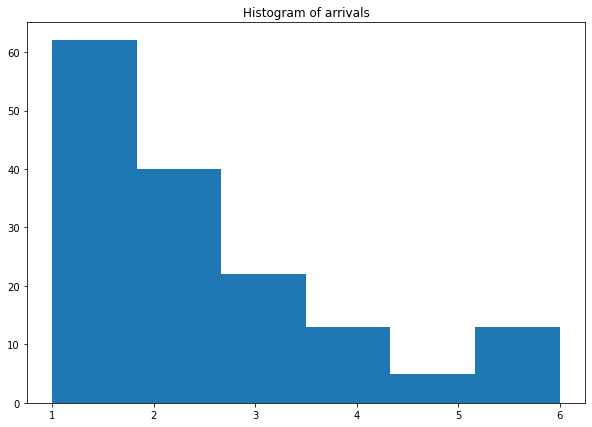

In [78]:
# round off arrivals
fig, ax = plt.subplots(figsize =(10, 7))
# mirror the arrivals to make it skewed for smaller arrivals compared to larger ones (can be removed if needed)
ax.hist([7-round(i) for i in arrival_rate],bins=6)
plt.title('Histogram of arrivals')